<a href="https://colab.research.google.com/github/mhmirj/asms/blob/master/notebooks/pytorch_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Dataset Integration Demo

In [5]:
%cd ..

/


In [6]:
!pip install numpy pandas xarray torch hydra-core dvc

In [7]:
%pip install "git+https://github.com/jejjohnson/xrpatcher.git"
%pip install torch --index-url https://download.pytorch.org/whl/cpu

  Cloning https://github.com/jejjohnson/xrpatcher.git to /tmp/pip-req-build-1g40qs7a
  Running command git clone --filter=blob:none --quiet https://github.com/jejjohnson/xrpatcher.git /tmp/pip-req-build-1g40qs7a
  Resolved https://github.com/jejjohnson/xrpatcher.git to commit 26edf343635fc6fc0659c554d9174a1abf8d3a12
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://download.pytorch.org/whl/cpu


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import torch
from xrpatcher import XRDAPatcher

import matplotlib.pyplot as plt
import itertools
import xarray as xr
import collections
import numpy as np

In [10]:
# import importlib
# importlib.reload(xrda)

## Torch dataset wrapper of the XRDAPatcher

In [11]:
class XrTorchDataset(torch.utils.data.Dataset):
    def __init__(self, batcher: XRDAPatcher, item_postpro=None):
        self.batcher = batcher
        self.postpro = item_postpro

    def __getitem__(self, idx):
        item = self.batcher[idx].load().values
        if self.postpro:
            item = self.postpro(item)
        return item

    def reconstruct_from_batches(self, batches, **rec_kws):
        return self.batcher.reconstruct([*itertools.chain(*batches)], **rec_kws)

    def __len__(self):
        return len(self.batcher)

## 1D - 1 variable, Patching Example

In [12]:
# Preparing the training data
raw_data = xr.tutorial.load_dataset("air_temperature")
TrainingItem = collections.namedtuple("TrainingItem", ("air",))
data = (
    raw_data[[*TrainingItem._fields]]
    .isel(lon=5, lat=5, time=slice(0, 1000))
    .sortby("time")
    .to_array()
    .transpose("variable", "time")
    .load()
)

# Instantiate the patching logic
patches = dict(time=200)
strides = dict(time=160)
batcher = XRDAPatcher(da=data, patches=patches, strides=strides, check_full_scan=True)


# Instantiate the
torch_ds = XrTorchDataset(batcher, item_postpro=TrainingItem._make)
dataloader = torch.utils.data.DataLoader(torch_ds, batch_size=4, shuffle=False)


items = [torch_ds[i] for i in range(len(torch_ds))]
ex_item = items[0]
batch = next(iter(dataloader))
print(f"Number of items: {len(torch_ds)}")
print(f"Item shape: {ex_item.air.shape=}")
print(f"Batch shape: {batch.air.shape=}")

Number of items: 6
Item shape: ex_item.air.shape=(200,)
Batch shape: batch.air.shape=torch.Size([4, 200])


### Visualizing the input data

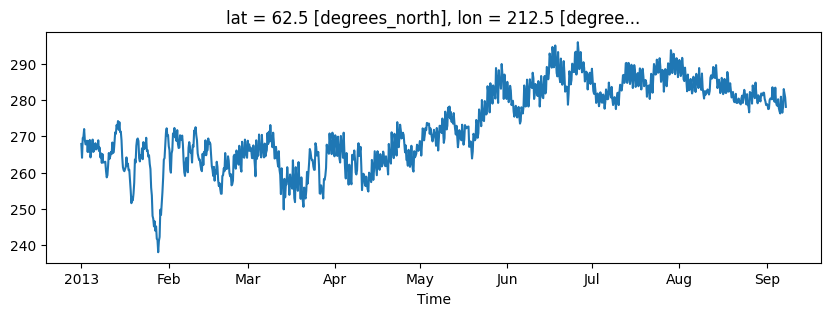

In [13]:
data.plot(figsize=(10, 3))

### Visualizing the items with the overlaps

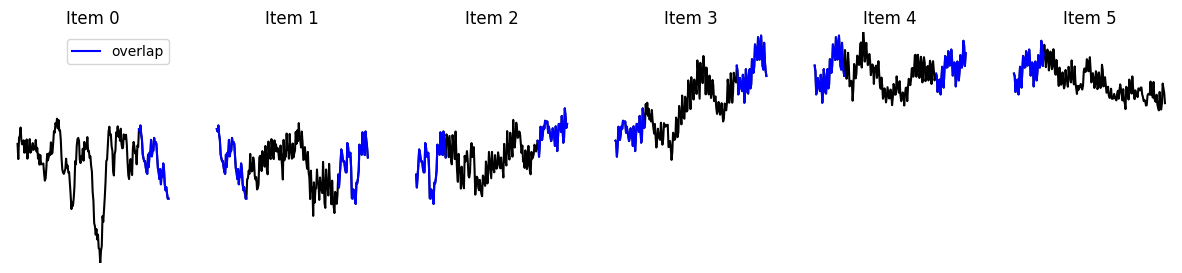

In [14]:
fig, axs = plt.subplots(1, 6, figsize=(15, 3))
for i, (item, ax) in enumerate(zip(items, axs)):
    ax.plot(
        item.air,
        "k",
    )
    l = None
    if i > 0:
        (l,) = ax.plot(range(40), item.air[:40], "b-", label="overlap")

    if i < 5:
        (l,) = ax.plot(range(160, 200), item.air[160:], "b-", label="overlap")
    if i == 0:
        ax.legend(handles=[l])
    ax.set_title(f"Item {i}")
    ax.set_ylim([data.min(), data.max()])
    ax.set_xticks([], labels=None)
    ax.set_axis_off()
    ax.set_yticks([], labels=None)

## 2D Patching Example

In [15]:
# Preparing the training data
raw_data = xr.tutorial.load_dataset("eraint_uvz")
TrainingItem = collections.namedtuple("TrainingItem", ("u", "v"))
data = (
    raw_data[[*TrainingItem._fields]]
    .isel(longitude=slice(None, 400), latitude=slice(None, 200), month=0, level=0)
    .sortby("longitude")
    .sortby("latitude")
    .to_array()
    .transpose("variable", "latitude", "longitude")
    .load()
)

# Instantiate the patching logic
patches = dict(longitude=100, latitude=50)
batcher = XRDAPatcher(
    da=data, patches=patches, strides=patches, check_full_scan=True  # No overlap
)


# Instantiate the
torch_ds = XrTorchDataset(batcher, item_postpro=TrainingItem._make)
dataloader = torch.utils.data.DataLoader(torch_ds, batch_size=4, shuffle=False)


items = [torch_ds[i] for i in range(len(torch_ds))]
ex_item = items[0]
batch = next(iter(dataloader))

print(f"Item shape: {ex_item.u.shape=}, {ex_item.v.shape=}")
print(f"Batch shape: {batch.u.shape=}, {batch.v.shape=}")

Item shape: ex_item.u.shape=(50, 100), ex_item.v.shape=(50, 100)
Batch shape: batch.u.shape=torch.Size([4, 50, 100]), batch.v.shape=torch.Size([4, 50, 100])


/usr/local/lib/python3.11/dist-packages/xarray/conventions.py:200: SerializationWarning: variable 'z' has non-conforming '_FillValue' nan defined, dropping '_FillValue' entirely.
  var = coder.decode(var, name=name)
/usr/local/lib/python3.11/dist-packages/xarray/conventions.py:200: SerializationWarning: variable 'u' has non-conforming '_FillValue' nan defined, dropping '_FillValue' entirely.
  var = coder.decode(var, name=name)
/usr/local/lib/python3.11/dist-packages/xarray/conventions.py:200: SerializationWarning: variable 'v' has non-conforming '_FillValue' nan defined, dropping '_FillValue' entirely.
  var = coder.decode(var, name=name)


In [16]:
print(
    f"Dataset length is {len(torch_ds)}, \n Number of patches per dims are {torch_ds.batcher.da_size}"
)

Dataset length is 16, 
 Number of patches per dims are OrderedDict([('variable', 1), ('latitude', 4), ('longitude', 4)])


### Vizualizing the patch process

#### Input data:

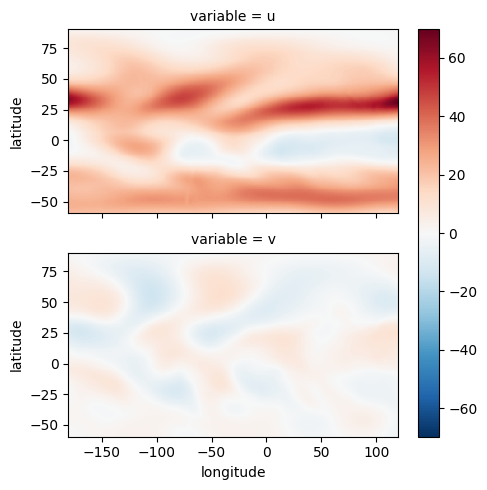

In [17]:
data.plot(row="variable", figsize=(5, 5))

#### Items drawn from the torch dataset

Patches of u


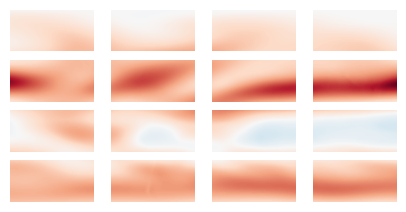



Patches of v


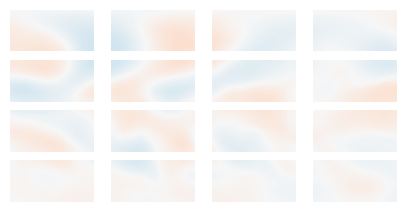

In [18]:
def plot_patches(items_to_plot, nbaxes=(4, 4)):
    fig, axs = plt.subplots(*nbaxes, figsize=(5, 2.5))

    for item, ax in zip(items_to_plot, [*itertools.chain(*reversed(axs))]):
        ax.imshow(item, cmap="RdBu_r", vmax=70, vmin=-70, origin="lower")
        ax.set_xticks([], labels=None)
        ax.set_axis_off()
        ax.set_yticks([], labels=None)


print("Patches of u")
plot_patches([i.u for i in items])
plt.show()

print("\n\nPatches of v")
plot_patches([i.v for i in items])

#### Reconstructing the amplitude of the speed from the patches

/usr/local/lib/python3.11/dist-packages/xrpatcher/_src/base.py:167: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  coords_labels = list(coords[0].dims.keys())
/usr/local/lib/python3.11/dist-packages/xrpatcher/_src/base.py:202: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  msg += f"\nCoords: {list(coords[0].dims.keys())}"
/usr/local/lib/python3.11/dist-packages/xrpatcher/_src/base.py:209: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names 

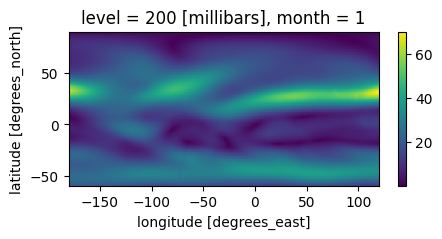

In [19]:
rec_ds = torch_ds.reconstruct_from_batches(
    (np.sqrt(batch.u**2 + batch.v**2) for batch in dataloader),
    dims_labels=["latitude", "longitude"],
)
rec_ds.plot(figsize=(5, 2))

#### Reconstructing the laplacian (~ vorticity) from the patches

/usr/local/lib/python3.11/dist-packages/xrpatcher/_src/base.py:167: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  coords_labels = list(coords[0].dims.keys())
/usr/local/lib/python3.11/dist-packages/xrpatcher/_src/base.py:202: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  msg += f"\nCoords: {list(coords[0].dims.keys())}"
/usr/local/lib/python3.11/dist-packages/xrpatcher/_src/base.py:209: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names 

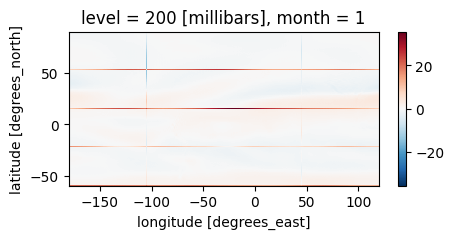

In [20]:
rec_ds = torch_ds.reconstruct_from_batches(
    (
        (np.diff(batch.u, axis=1, prepend=0) + np.diff(batch.v, axis=2, prepend=0))
        for batch in dataloader
    ),
    dims_labels=["latitude", "longitude"],
)
rec_ds.plot(figsize=(5, 2))

**We see that the border of the patches creates artifact during the derivative: We can fix it by using overlapping patches**

#### Solution with overlapping patches (stride smaller than patch size)


/usr/local/lib/python3.11/dist-packages/xrpatcher/_src/base.py:167: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  coords_labels = list(coords[0].dims.keys())
/usr/local/lib/python3.11/dist-packages/xrpatcher/_src/base.py:202: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  msg += f"\nCoords: {list(coords[0].dims.keys())}"
/usr/local/lib/python3.11/dist-packages/xrpatcher/_src/base.py:209: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names 

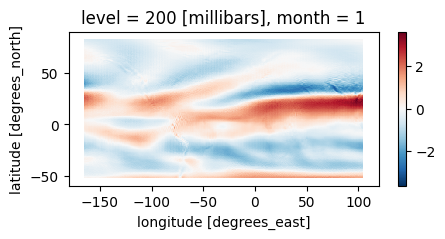

In [21]:
patches = dict(longitude=100, latitude=50)
strides = dict(longitude=60, latitude=30)
batcher = XRDAPatcher(da=data, patches=patches, strides=strides, check_full_scan=True)

rec_weight = np.ones((50, 100))  # Weight for each pixel of one patch
rec_weight[:10] = 0  # do not use the border pixels during the reconstruction
rec_weight[:, :20] = 0
rec_weight[-10:] = 0
rec_weight[:, -20:] = 0

# Instantiate the
torch_ds = XrTorchDataset(batcher, item_postpro=TrainingItem._make)
dataloader = torch.utils.data.DataLoader(torch_ds, batch_size=4, shuffle=False)
rec_ds = torch_ds.reconstruct_from_batches(
    (
        (np.diff(batch.u, axis=1, prepend=0) + np.diff(batch.v, axis=2, prepend=0))
        for batch in dataloader
    ),
    dims_labels=["latitude", "longitude"],
    weight=rec_weight,
)
rec_ds.plot(figsize=(5, 2))

Patches of u with overlap


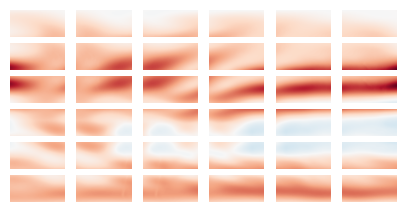



Patches of u with reconstruction mask


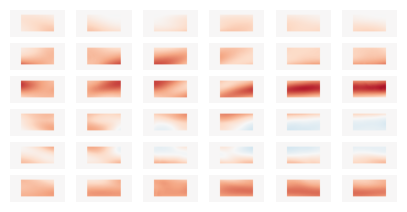

In [22]:
print("Patches of u with overlap")
plot_patches([torch_ds[i].u for i in range(len(torch_ds))], (6, 6))
plt.show()
print("\n\nPatches of u with reconstruction mask")
plot_patches([torch_ds[i].u * rec_weight for i in range(len(torch_ds))], (6, 6))

In [30]:
# گرفتن یک batch از dataloader
batch = next(iter(dataloader))

# نمایش تمام ویژگی‌های batch
print("ویژگی‌های batch:")
print(dir(batch))

# اگر batch یک ساختار دیکشنری مانند باشد (مثلاً _asdict)، آن را چاپ می‌کنیم:
if hasattr(batch, '_asdict'):
    print("\nمحتوای batch به صورت دیکشنری:")
    print(batch._asdict())


ویژگی‌های batch:
['__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_asdict', '_field_defaults', '_fields', '_make', '_replace', 'count', 'index', 'u', 'v']

محتوای batch به صورت دیکشنری:
{'u': tensor([[[20.3744, 20.3744, 20.3131,  ..., 17.4382, 17.3752, 17.3752],
         [21.1246, 21.1875, 21.1246,  ..., 18.6256, 18.5626, 18.6256],
         [21.8748, 21.9377, 21.8748,  ..., 19.8743, 19.8129, 19.8129],
         ...,
         [19.1870, 19.3128, 19.2499,  ...,  7.4059,  7.6402,  7.9217],
         [18.0625, 18.1254, 18.0625,  ...,  7.8132,  8.0633,  8.37

In [32]:
reconstructed_data = torch_ds.reconstruct_from_batches(
    (batch.u for batch in dataloader),
    dims_labels=["latitude", "longitude"]
).values

print("Reconstructed Data Shape:", reconstructed_data.shape)


/usr/local/lib/python3.11/dist-packages/xrpatcher/_src/base.py:209: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  msg += f"\nCoords: {list(coords[0].dims.keys())}"
100%|██████████| 36/36 [00:00<00:00, 103.72it/s]

Reconstructed Data Shape: (200, 400)


In [33]:
import numpy as np

# فرض می‌کنیم data.values شکل (200, 400) داشته باشد
true_data = data.values
rmse = np.sqrt(np.mean((true_data - reconstructed_data) ** 2))
print(f"RMSE: {rmse}")

RMSE: 15.618022761719532


In [34]:
import numpy as np

# داده‌های واقعی
true_data = data.values

# داده‌های بازسازی‌شده از پچ‌ها
reconstructed_data = torch_ds.reconstruct_from_batches(
    (batch.u for batch in dataloader),
    dims_labels=["latitude", "longitude"]
).values

# محاسبه RMSE
rmse = np.sqrt(np.mean((true_data - reconstructed_data) ** 2))
print(f"RMSE for 1D Data: {rmse}")


/usr/local/lib/python3.11/dist-packages/xrpatcher/_src/base.py:167: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  coords_labels = list(coords[0].dims.keys())
/usr/local/lib/python3.11/dist-packages/xrpatcher/_src/base.py:202: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  msg += f"\nCoords: {list(coords[0].dims.keys())}"
/usr/local/lib/python3.11/dist-packages/xrpatcher/_src/base.py:209: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names 

RMSE for 1D Data: 15.618022761719532
